In [1]:
from Helpers import *

In [30]:
def f(x,u):
    g = 9.81
    L = .5
    return np.array([x[1],-g/L*sin(x[0])+u[0]])

def fx(x,u):
    g = 9.81
    L = .5
    return np.array([[0,1],[-g/L*cos(x[0]),0]])

def fu(x,u):
    return np.array([0,1]).reshape((2,1))

def l(x,u,r1):
    return r1*u[0]**2

def lx(x,u):
    return np.zeros(2)

def lu(x,u,r1):
    return r1*2*u[0]

def lxx(x,u):
    return np.zeros((2,2))

def luu(x,u,r1):
    return r1*2

def h(x,w1,w2,xtarg):
    return w1*((x[0]-xtarg)*(x[0]-xtarg)) + w2*x[1]*x[1]

def hx(x,w1,w2,xtarg):
    return np.array([w1*2*(x[0]-xtarg),w2*2*x[1]])

def hxx(x,w1,w2):
    return np.array([[w1*2,0],[0,w2*2]])

In [29]:
def step1(x0,u,Duration):
    K = np.shape(u)[0]+1
    dt = Duration/(K-1)
    newx = np.zeros((K,len(x0)))
    newx[0] = x0
    for i in range(K-1):
        newx[i+1] = newx[i] + dt*f(newx[i],u[i])
    return newx

def step2(x,u,Duration,w1,w2,r1,xtarg):
    n = len(x[0])
    m = len(u[0])
    K = np.shape(u)[0]+1
    dt = Duration/(K-1)
    A = np.zeros((K-1,n,n))
    B = np.zeros((K-1,n,m))
    q = np.zeros(K)
    qbold = np.zeros((K,n))
    r = np.zeros((K-1,m))
    Q = np.zeros((K,2,n))
    R = np.zeros((K-1,m,m))
    for i in range(K-1):
        A[i] = np.identity(2)+dt*fx(x[i],u[i])
        B[i] = dt*fu(x[i],u[i])
        q[i] = dt*l(x[i],u[i],r1)
        qbold[i] = dt*lx(x[i],u[i])
        r[i] = dt*lu(x[i],u[i],r1)
        Q[i] = dt*lxx(x[i],u[i])
        R[i] = dt*luu(x[i],u[i],r1)

    q[K-1] = h(x[K-1],w1,w2,xtarg)
    qbold[K-1] = hx(x[K-1],w1,w2,xtarg)
    Q[K-1] = hxx(x[K-1],w1,w2)
    return A,B,q,qbold,r,Q,R

def step3(A,B,C,cbold,q,qbold,r,Q,R):
    # C should be nxm 
    # c should be nx1

    K = A.shape[0]+1
    n,m = np.shape(B[0])
    S = np.zeros((K,n,n))
    s = np.zeros(K)
    sbold = np.zeros((K,n))
    l = np.zeros((K-1,m))
    L = np.zeros((K-1,m,n))

    S[-1] = Q[-1]
    s[-1] = q[-1]
    sbold[-1] = qbold[-1]

    for k in np.arange(K-2,-1,-1):
        gbold = r[k] + B[k].T@sbold[k+1]+np.sum(C[k,:].T@S[k+1]@cbold[k,:])
        G = B[k].T@S[k+1]@A[k]
        H = R[k] + B[k].T@S[k+1]@B[k]+np.sum(C[k,:].T@S[k+1]@C[k,:])
        Hinv = np.linalg.inv(H)


        S[k] = Q[k] + A[k].T@S[k+1]@A[k]-G.T@Hinv@G
        sbold[k] = qbold[k]+A[k].T@sbold[k+1]-G.T@Hinv@gbold
        s[k] = q[k] + s[k+1] + 0.5*np.sum(cbold[k,:].T@S[k+1]@cbold[k,:]) - .5*gbold.T@Hinv@gbold

        l[k] = -Hinv@gbold
        L[k] = -Hinv@G
    
    return l,L

def step4(l,L,K,A,B):
    m,n = L[0].shape
    x = np.zeros(n)
    u_incr = np.zeros((K-1,m))
    for k in range(K-1):
        u_incr[k] = l[k]+L[k]@x
        x = A[k]@x+B[k]@u_incr[k]
    return u_incr

In [35]:
def ILQG_SingleArm(Duration,w1,w2,r1,xtarg,K):
    x0 = np.array([pi/2,0])
    u = np.zeros((K-1,1))
    C = np.zeros((K,2,1))
    cbold = np.zeros((K,2))
    u_incr = [1]

    while np.max(u_incr) > 1e-6: 
        
        x = step1(x0,u,Duration)
        A,B,q,qbold,r,Q,R = step2(x,u,Duration,w1,w2,r1,xtarg)
        l,L = step3(A,B,C,cbold,q,qbold,r,Q,R)
        u_incr = step4(l,L,K,A,B)
        u += u_incr

    x = step1(x0,u,Duration)
    return x,u


In [55]:
def plotLQGvsILQG(xLQG,uLQG,xILQG,uILQG,Duration,xtarg,K):
    plt.plot(np.linspace(0,Duration,K),xLQG[:]/(2*pi)*360,label = "LQG")
    plt.plot(np.linspace(0,Duration,K),xILQG[:,0]/(2*pi)*360,label = "ILQG")
    plt.plot(np.linspace(0,Duration,K),np.ones(K)*xtarg/(2*pi)*360,color = "black", linestyle = "--",alpha = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Angle [Degree]")
    plt.ylim(-90,90)
    plt.title("ILQG Trajectory on Single-Arm Pendulum")
    plt.legend()
    plt.show()

    plt.plot(np.linspace(0,Duration,K)[:-1],uLQG[:,0],label = "LQG")
    plt.plot(np.linspace(0,Duration,K)[:-1],uILQG[:,0],label = "ILQG")
    plt.xlabel("Time [sec]")
    plt.ylabel("Command (Nm)")
    plt.legend()
    plt.show()

In [51]:
def SingleArmLQG(Duration,w1,w2,r1,targ,K,Noise_Variance = 1e-12):

    Num_iter = K
    dt = Duration/Num_iter

    x0 = np.array([pi/2,0,targ])
    Num_Var = 3
    
    #Define Weight Matrices

    R = np.array([r1])
    Q = np.array([[w1,0,-w1],[0,w2,0],[-w1,0,w1]])
    
    
    #Define Dynamic Matrices  
    g = 9.81
    L = .5
    A = np.identity(3)+dt*np.array([[0,1,0],[-g/L,0,0],[0,0,0]])

    B = np.transpose([[0],[dt],[0]]).reshape((Num_Var,1))
    
    S = Q

    
    array_L = np.zeros((Num_iter-1,1,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    L= array_L
        
    array_u = np.zeros((Num_iter-1,1))
    array_x_nonlin = np.zeros((Num_iter,Num_Var)) 
    array_x_nonlin[0] = x0
    x = np.copy(x0)

    x_nonlin = np.copy(x0)
    new_x_nonlin = np.copy(x0)

    g = 9.81
    ArmLength = .5
    for k in range(Num_iter-1):
        

        x = np.copy(x_nonlin)     
        

        u = -L[k].reshape(np.flip(B.shape))@x
        
        array_u[k] = u[0]
        new_x_nonlin[0] += dt*x_nonlin[1]
        new_x_nonlin[1] += dt*u[0]-dt*g/ArmLength*sin(x_nonlin[0])
        new_x_nonlin[2] = x_nonlin[2]
            
        array_x_nonlin[k+1] = new_x_nonlin.flatten()
        x_nonlin = new_x_nonlin   

#Plot
    x_nonlin = array_x_nonlin[:,0]

    return x_nonlin,array_u

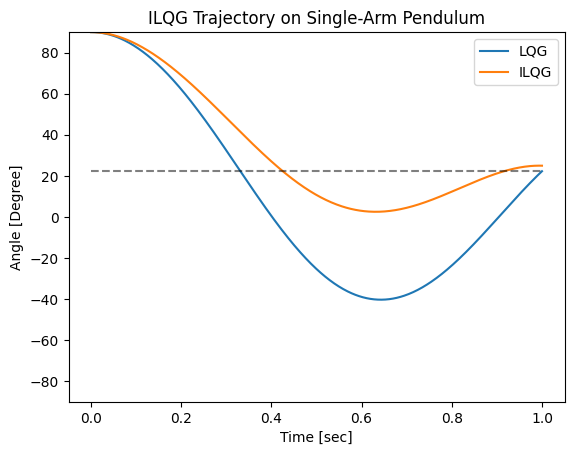

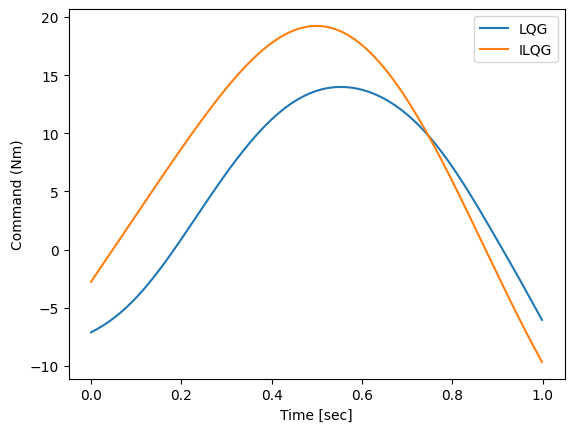

In [56]:
w1 = 1e6
w2 = 1e2
r1 = 1e-1
Duration = 1
xtarg = pi/8
K = 600
xILQG,uILQG = ILQG_SingleArm(Duration,w1,w2,r1,xtarg,K)
xLQG,uLQG = SingleArmLQG(Duration,w1,w2,r1,xtarg,K)
plotLQGvsILQG(xLQG,uLQG,xILQG,uILQG,Duration,xtarg,K)